In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # import Axes3D from `mpl_toolkits.mplot3d`
import matplotlib.animation as animation
import math
import random
from scipy.fft import fft, ifft
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
import levy as pylevy

plt.style.use('ggplot') # use "ggplot" style for graphs
random.seed()

In [2]:
# Function implementing Levy flight according to doi:10.1016/j.cor.2011.09.026
def levy(n, m, beta, nump=1):
    # nump = number of particles, default 1
    # n = number of steps
    # m = number of dimensions
    # beta = power law index, where 1 < beta < 2
    
    # Used for numerator
    num = math.gamma(1+beta)*math.sin(math.pi*beta/2)
    
    # Used for denominator
    den = math.gamma((1+beta)/2)*beta*2**((beta-1)/2)
    
    # Standard deviation
    sigma_u = (num/den)**(1/beta)
    
    # Draw samples
    if nump == 1:
        u = np.random.normal(scale=sigma_u**2, size=(n,m))
        v = np.random.normal(size=(n,m))
    else:
        u = np.random.normal(scale=sigma_u**2, size=(nump,n,m))
        v = np.random.normal(size=(nump,n,m))
    
    # n levy steps in m dimensions
    levyd = u/(np.power(np.abs(v), 1/beta))
    
    return levyd

# Function to determine value of alpha
def alpha(n, m, beta, alpha0, nump=1):
    lev_i = levy(n, m, beta, nump)
    lev_j = levy(n, m, beta, nump)
    
    if nump == 1:
        sol_i = np.zeros((n,m))
        sol_j = np.zeros((n,m))
        for i in range(1,n):
            sol_i[i,:] = sol_i[i-1,:] + lev_i[i,:]
            sol_j[i,:] = sol_j[i-1,:] + lev_j[i,:]
    
    else:
        sol_i = np.zeros((nump,n,m))
        sol_j = np.zeros((nump,n,m))
        for i in range(1,n):
            sol_i[:,i,:] = sol_i[:,i-1,:] + lev_i[:,i,:]
            sol_j[:,i,:] = sol_j[:,i-1,:] + lev_j[:,i,:]

    
    alpha = alpha0*(sol_j-sol_i)
    
    return alpha

def fourier_levy(k,alpha,beta):
    
    Fk = np.exp(-alpha*np.power(np.abs(k), beta))
    invF = ifft(Fk)
    
    return invF

def gaussian(x, sig):
    return np.exp(-np.power(x - 0, 2.) / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi)*sig)

def cauchy(x, gamma):
    return (1/(np.pi))*((gamma)/(np.power(x, 2)+gamma**2))

def anom_diff(t, K, a):
    return K*np.power(t, a)

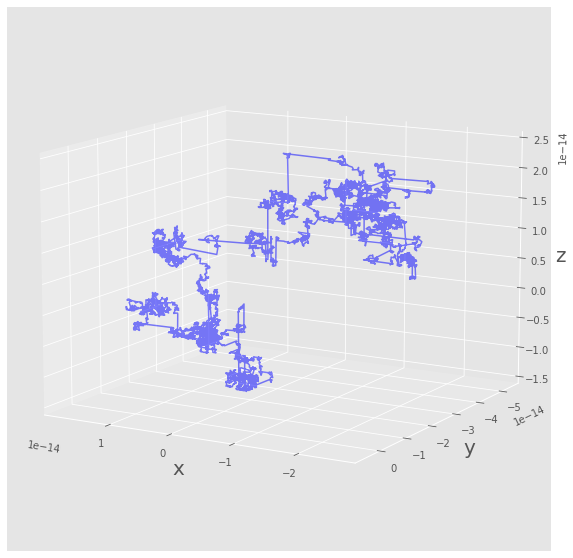

In [3]:
# Set parameters
num = 500 # number of particles
alpha0 = 0.1 # alpha0 parameter
var = alpha0*2
n = 10000 # number of steps
m = 3 # dimensions
beta = 2 # power law index

x = np.zeros(n)
y = np.zeros(n)
z = np.zeros(n)

xg = np.zeros(n)
yg = np.zeros(n)
zg = np.zeros(n)

# Generate levy steps
lev = levy(n,m,beta)
gauss = np.random.normal(loc=0, scale=var/2, size=(n,m))
#lev = lev*10**(15)

alph = alpha(n,m,beta,alpha0)

"""for i in range(1,len(lev)):
    x[i] = x[i-1] + lev[i,0]
    y[i] = y[i-1] + lev[i,1]
    z[i] = z[i-1] + lev[i,2]"""
    
for i in range(1,n):
    #x[i] = x[i-1] + np.multiply(alph[i,0],lev[i,0])
    #y[i] = y[i-1] + np.multiply(alph[i,1],lev[i,1])
    #z[i] = z[i-1] + np.multiply(alph[i,2],lev[i,2])
    x[i] = x[i-1] + lev[i,0]
    y[i] = y[i-1] + lev[i,1]
    z[i] = z[i-1] + lev[i,2]
    
for i in range(1,n):
    xg[i] = xg[i-1] + gauss[i,0]
    yg[i] = yg[i-1] + gauss[i,1]
    zg[i] = zg[i-1] + gauss[i,2]

# Plot
#jet= plt.get_cmap('jet')
#colors = iter(jet(np.linspace(0,1,num)))

fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
ax.plot(x,y,z,color='b',alpha=0.5) # plot trajectiries of all particle
#ax.plot(xg,yg,zg,color='r',alpha=0.5) # plot trajectiries of all particle
plt.savefig('Figures/levy flight gaussian 3D single.pdf', bbox_inches='tight')
plt.savefig('Figures/levy flight gaussian 3D single.png', bbox_inches='tight')
plt.show() # draw plots

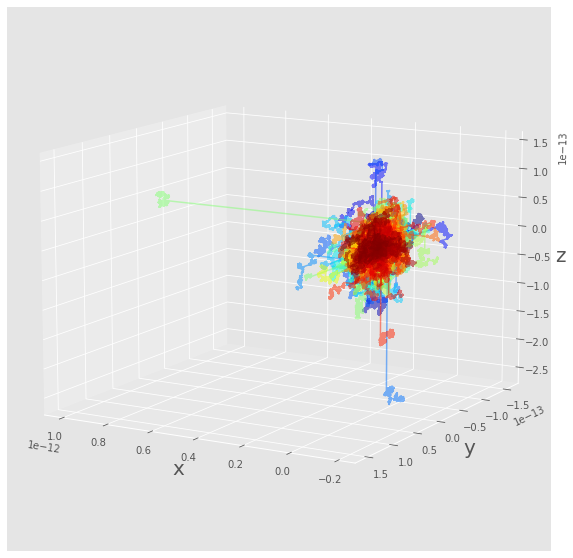

In [4]:
x = np.zeros((num,n))
y = np.zeros((num,n))
z = np.zeros((num,n))

# Generate levy steps
lev = levy(n,m,beta,num)

alph = alpha(n,m,beta,alpha0,num)

for i in range(1,n):
    #x[:,i] = x[:,i-1] + np.multiply(alph[:,i,0], lev[:,i,0])
    #y[:,i] = y[:,i-1] + np.multiply(alph[:,i,1], lev[:,i,1])
    #z[:,i] = z[:,i-1] + np.multiply(alph[:,i,2], lev[:,i,2])
    x[:,i] = x[:,i-1] + lev[:,i,0]
    y[:,i] = y[:,i-1] + lev[:,i,1]
    z[:,i] = z[:,i-1] + lev[:,i,2]

# Plot
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,num)))

fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
for i in range(num): # repeat from n=0 to nump-1
    ax.plot(x[i,:],y[i,:],z[i,:],alpha=0.5, color=next(colors)) # plot trajectiries of all particle
plt.savefig('Figures/levy flight gaussian 3D paths.pdf', bbox_inches='tight')
plt.savefig('Figures/levy flight gaussian 3D paths.png', bbox_inches='tight')
plt.show() # draw plots

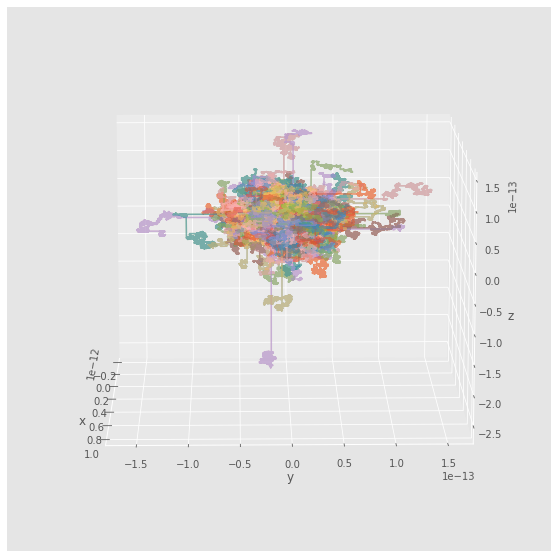

In [5]:
#jet= plt.get_cmap('jet')
#colors = iter(jet(np.linspace(0,1,num)))

# Create a figure and a 3D Axes
fig = plt.figure(figsize=(10,10)) # set fig with its size 10 x 10 inch
ax = fig.add_subplot(111,projection='3d') # creates an additional axis to the standard 
ax.set_xlabel(r"x",fontsize=12) # set x-label
ax.set_ylabel(r"y",fontsize=12) # set y-label
ax.set_zlabel(r"z",fontsize=12) # set z-label

# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    for i in range(num): # repeat from n=0 to nump-1
        ax.plot(x[i,:],y[i,:],z[i,:],alpha=0.5) # plot trajectiries of all particle
    return fig,

def animate(i):
    ax.view_init(elev=12., azim=i)
    return fig,

# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save(r'Figures/gaussian 3D rotation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

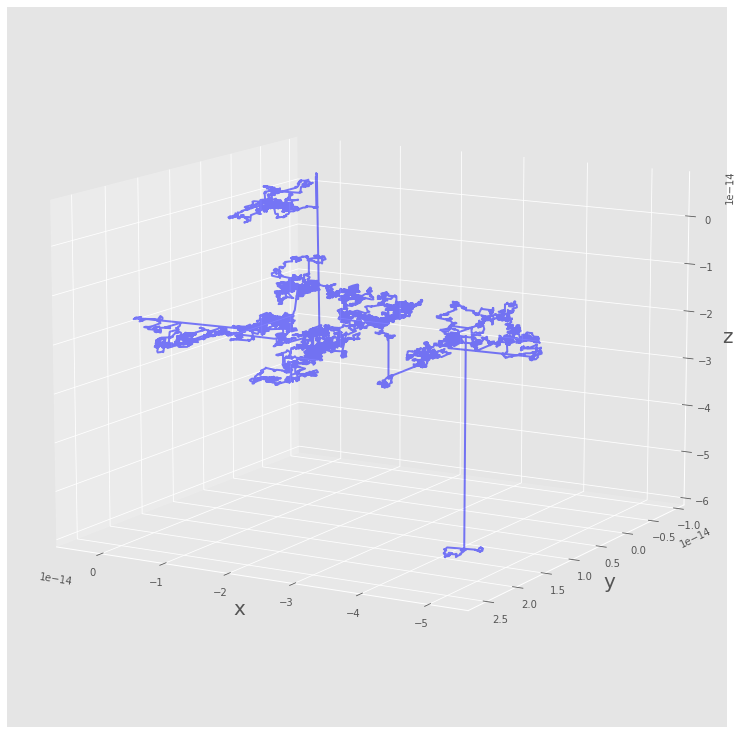

In [6]:
# ANIMATION FUNCTION
def func(nums, dataSet, line):
    # NOTE: there is no .set_data() for 3 dim data...
    line.set_data(dataSet[0:2, :nums])    
    line.set_3d_properties(dataSet[2, :nums])    
    return line

# THE DATA POINTS
dataSet = np.array([x[0,:], y[0,:], z[0,:]])
numDataPoints = len(x[0,:])
 
# GET SOME MATPLOTLIB OBJECTS
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
 
# NOTE: Can't pass empty arrays into 3d version of plot()
line = plt.plot(dataSet[0], dataSet[1], dataSet[2], alpha=0.5, lw=2, c='b')[0] # For line plot
 
# AXES PROPERTIES]
# ax.set_xlim3d([limit0, limit1])
#ax.set_xlim3d(0,nx) # set x-range
#ax.set_ylim3d(0,ny) # set y-range
#ax.set_zlim3d(0,nz) # set z-range
ax.set_xlabel(r"x",fontsize=20) # set x-label
ax.set_ylabel(r"y",fontsize=20) # set y-label
ax.set_zlabel(r"z",fontsize=20) # set z-label
ax.view_init(elev=12,azim=120) # set view point
 
# Creating the Animation object
line_ani = animation.FuncAnimation(fig, func, frames=numDataPoints, fargs=(dataSet,line), interval=5, blit=False)
line_ani.save(r'Figures/gaussian 3D single.mp4')

plt.show() # draw plots

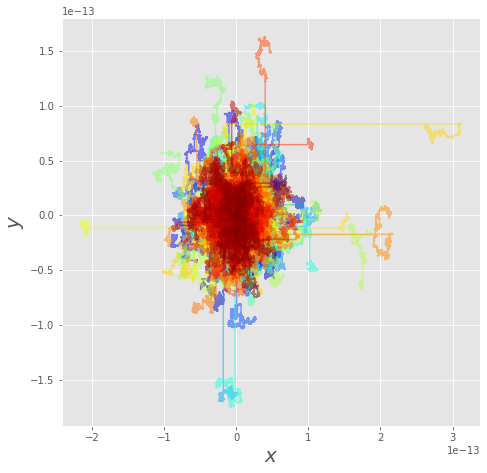

In [50]:
jet= plt.get_cmap('jet')
colors = iter(jet(np.linspace(0,1,num)))

fig, ax = plt.subplots(figsize=(7.5,7.5)) # set fig with its size 7.5 x 7.5 inch
#ax.set_title('{:.1f} ms'.format(nums*dt*1000))
ax.set_xlabel(r"$x$", fontsize=20) # set x-label
ax.set_ylabel(r"$y$", fontsize=20) # set y-label
#ax.set_xlim(0,nx) # set x-range
#ax.set_ylim(0,ny) # set y-range
for i in range(num): # repeat from n=0 to nump-1
    ax.plot(x[i,:],y[i,:],color=next(colors),alpha=0.5) # plot trajectiries of all particles
plt.savefig('Figures/levy flight gaussian 2D paths.pdf', bbox_inches='tight')
plt.show() # draw plots

0
3.558972365072228e-16
-1.779486182536114e-15
1.779486182536114e-15
50
[1.24245751e-16]


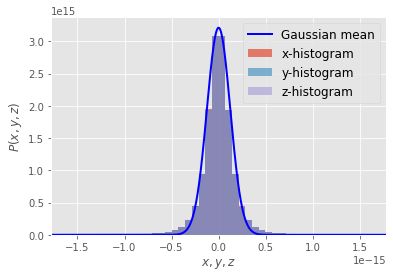

In [51]:
x_diff = np.diff(x, axis=1)
y_diff = np.diff(y, axis=1)
z_diff = np.diff(z, axis=1)

x_diff = x_diff.flatten()
y_diff = y_diff.flatten()
z_diff = z_diff.flatten()

#print(np.amax(x_diff))
#print(np.amin(x_diff))

#print(np.amax(y_diff))
#print(np.amin(y_diff))

#print(np.amax(z_diff))
#print(np.amin(z_diff))

stepsize_array = np.concatenate((x_diff,y_diff,z_diff), axis=None)
(ave, std) = norm.fit(stepsize_array,floc=0)

#lev_param = pylevy.fit_levy(np.mean([x_diff,y_diff,z_diff], axis=0))
#print(lev_param)
#lev_alpha, lev_beta, lev_ave, lev_std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 50
print(ave)
print(std)
print(nmin)
print(nmax)
print(nbin)

fig = plt.figure()
ax = fig.add_subplot(111)

height1, _, _ = ax.hist(x_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
height2, _, _ = ax.hist(y_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
height3, _, _ = ax.hist(z_diff,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L
height4, bins, _ = ax.hist(stepsize_array,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0) # plot to get parameters, dont want visible

bin_centers = bins[:-1] + np.diff(bins) / 2

popt, _ = curve_fit(gaussian, bin_centers, height4, p0=[2e-16])
print(popt)

best_fit_line = norm.pdf(bins, ave, std)

xyz_fit = np.linspace(bins[0], bins[-1], 10000)
#levy_line = pylevy.levy(z_fit, lev_alpha, lev_beta, lev_ave, lev_std)

ax.plot(xyz_fit, gaussian(xyz_fit, *popt),lw=2,color='b', label=r'Gaussian mean')
#ax.plot(bins,best_fit_line,lw=2,color='k',label=r'Norm fit') # plot y vs. x with blue line
#ax.plot(bins,levy_line,lw=2,color='r',label=r'Levy fit') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy gaussian xyz step size.pdf', bbox_inches='tight')
plt.show() # display plots

3.954856459200247e-14
0
3.962666048360526e-14
[3.22897092e-14]


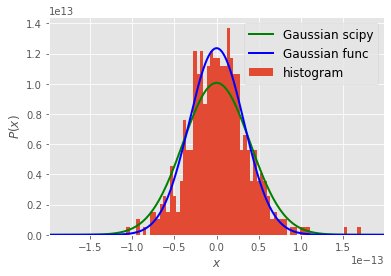

In [52]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
(ave, std) = norm.fit(x[:,-1],floc=0)
print(np.std(x[:,-1]))

#lev_param = pylevy.fit_levy(x[:,-1])
#print(lev_param)
#lev_alpha, lev_beta, lev_ave, lev_std = lev_param[0].get('0')

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(x[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, label=r'histogram') # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

best_fit_line = norm.pdf(bins, ave, std)

popt, _ = curve_fit(gaussian, bin_centers, height, p0=[2e-14])
print(popt)

x_fit = np.linspace(bins[0], bins[-1], 10000)
#levy_line = pylevy.levy(x_fit, lev_alpha, lev_beta, lev_ave, lev_std)

#ax.plot(xi,yi,lw=2,color='k', label=r'Gaussian') # plot y vs. x with blue line
ax.plot(bins,best_fit_line,lw=2,color='g', label=r'Gaussian scipy') # plot y vs. x with blue line
ax.plot(x_fit, gaussian(x_fit, *popt),lw=2,color='b', label=r'Gaussian func')
#ax.plot(x_fit, levy_line,lw=2,color='k', label=r'Levy with $\beta=2$')
#ax.set_title(r'x-axis particle distribution')
ax.set_xlabel(r'$x$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight gaussian x distr.pdf', bbox_inches='tight')
plt.show() # display plots

3.4094319223194746e-14
0
3.4121520449950346e-14
[3.00990601e-14]


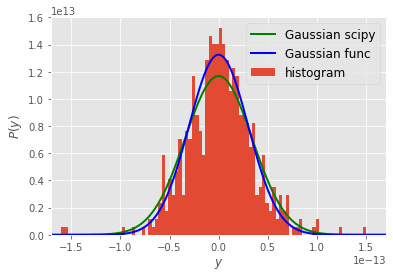

In [53]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
(ave, std) = norm.fit(y[:,-1],floc=0)
print(np.std(y[:,-1]))

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(y[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, label=r'histogram') # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

best_fit_line = norm.pdf(bins, ave, std)

popt, _ = curve_fit(gaussian, bin_centers, height, p0=[2e-14])
print(popt)

y_fit = np.linspace(bins[0], bins[-1], 10000)

#ax.plot(xi,yi,lw=2,color='k', label=r'Gaussian') # plot y vs. x with blue line
ax.plot(bins,best_fit_line,lw=2,color='g', label=r'Gaussian scipy') # plot y vs. x with blue line
ax.plot(y_fit, gaussian(y_fit, *popt),lw=2,color='b', label=r'Gaussian func')
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$y$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(y)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight gaussian y distr.pdf', bbox_inches='tight')
plt.show() # display plots

3.199991510739675e-14
0
3.2047453776205895e-14
[2.97931745e-14]


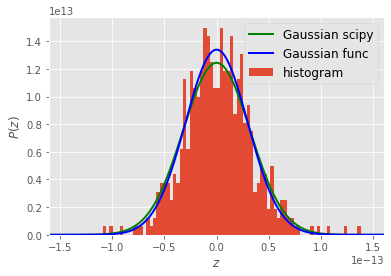

In [54]:
#ave = 0 # Average position i.e. starting position
#std = np.sqrt(2*dmsd*t[-1]) # Standard deviation i.e. sqrt(2Dt)
(ave, std) = norm.fit(z[:,-1],floc=0)
print(np.std(z[:,-1]))

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height, bins, _ = ax.hist(z[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, label=r'histogram') # plot normalized histogram of L
bin_centers = bins[:-1] + np.diff(bins) / 2

#xi = np.arange(nmin,nmax,0.01/std) # create array of x from nmin to nmax with increment
#yi = np.exp(-(xi-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

best_fit_line = norm.pdf(bins, ave, std)

popt, _ = curve_fit(gaussian, bin_centers, height, p0=[2e-14])
print(popt)

z_fit = np.linspace(bins[0], bins[-1], 10000)

#ax.plot(xi,yi,lw=2,color='k', label=r'Gaussian') # plot y vs. x with blue line
ax.plot(bins,best_fit_line,lw=2,color='g', label=r'Gaussian scipy') # plot y vs. x with blue line
ax.plot(z_fit, gaussian(z_fit, *popt),lw=2,color='b', label=r'Gaussian func')
#ax.set_title(r'z-axis particle distribution')
ax.set_xlabel(r'$z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight gaussian z distr.pdf', bbox_inches='tight')
plt.show() # display plots

0
2.013617396934738e-14
[3.05012434e-14]


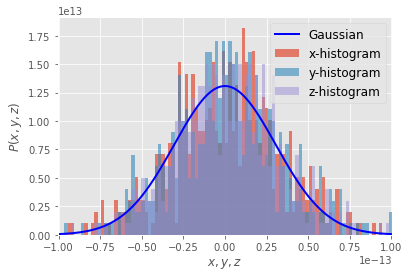

In [55]:
(ave, std) = norm.fit(np.mean([x[:,-1],y[:,-1],z[:,-1]], axis=0),floc=0)
stepsize_array = np.concatenate((x[:,-1],y[:,-1],z[:,-1]), axis=None)
(ave1, std1) = norm.fit(stepsize_array,floc=0)

nmin=ave-std*5
nmax=ave+std*5
nbin=int((nmax-nmin)/4)
nbin = 100
print(ave)
print(std)

fig = plt.figure()
ax = fig.add_subplot(111)

height1, bins, _ = ax.hist(x[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
height2, _, _ = ax.hist(y[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
height3, _, _ = ax.hist(z[:,-1],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L
height4, bins, _ = ax.hist(stepsize_array,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0) # plot to get parameters, dont want visible

bin_centers = bins[:-1] + np.diff(bins) / 2

popt, _ = curve_fit(gaussian, bin_centers, height4, p0=[2e-16])
print(popt)

best_fit_line = norm.pdf(bins, ave, std)
best_fit_line1 = norm.pdf(bins, ave1, std1)

xyz_fit = np.linspace(bins[0], bins[-1], 10000)

ax.plot(xyz_fit, gaussian(xyz_fit, *popt),lw=2,color='b', label=r'Gaussian')
#ax.plot(xyz_fit, gaussian(xyz_fit, *popt1),lw=2,color='c', label=r'Gaussian mean')
#ax.plot(bins,best_fit_line,lw=2,color='k',label=r'Norm fit mean') # plot y vs. x with blue line
#ax.plot(bins,best_fit_line1,lw=2,color='r',label=r'Norm fit') # plot y vs. x with blue line
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=12, loc='upper right') # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy flight gaussian xyz distr.pdf', bbox_inches='tight')
plt.show() # display plots

D = 6.357609553491641e-32 (Simulation via MSD)


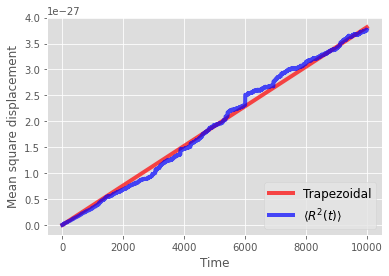

In [56]:
R = np.zeros((num,n,m))
R[:,:,0] = x[:,:]
R[:,:,1] = y[:,:]
R[:,:,2] = z[:,:]
dt = 1
time = np.arange(n)

# mean square displacement vs time
msd1 = np.zeros([n, num])
for i in range(n): # loop over time steps
    diff = R[:,i,:] - 0
    pos2 = np.power(diff, 2)
    summ = np.sum(pos2, axis=1)
    msd1[i,:] = summ
    
msd = np.mean(msd1, axis=1)
#print(msd1)
#print(msd)

dmsd = np.trapz(msd, dx=dt)/ (3*(n*dt)**2) # integrate using trapezoidal rule

"""fit = np.polyfit(time, msd, 1)
print('Fitted D =',fit[0]/6,'in cm^2 min^-1')
d1 = fit[0]/6

predict = np.poly1d(fit)
theory = predict(time)"""

#popt, _ = curve_fit(anom_diff, time, msd, p0=[6.9e-32, 1])
#print(popt)

dmsdfit = 6*dmsd*time

#print('D =',kBT/zeta,'(Theoretical)')
print('D =',dmsd,'(Simulation via MSD)')

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel(r"Time",fontsize=12)
ax.set_ylabel(r"Mean square displacement",fontsize=12)
#ax.plot(time,anom_diff(time, *popt),'g',lw=4, alpha=0.7, label=r'Fitted anomalous')
ax.plot(time,dmsdfit,'r',lw=4, alpha=0.7, label=r'Trapezoidal')
ax.plot(time,msd,'b',lw=4, alpha=0.7, label=r'$\langle R^2(t)\rangle$')
ax.legend(fontsize=12,loc=4)
plt.savefig('Figures/levy flight gaussian msd.pdf', bbox_inches='tight')
plt.show()

3.5656622926284797e-14
[3.0733821e-14]


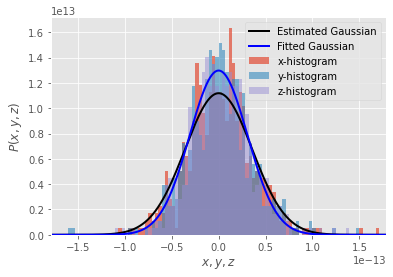

In [77]:
y = R[:,:,1]
ave = 0 # Average position i.e. starting position
std = np.sqrt(2*dmsd*time[n-1]) # Standard deviation i.e. sqrt(2Dt)
print(std)

nmin=ave-std*5
nmax=ave+std*5
nbin=100

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(x[:,n-1]-x[:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.7,label=r'x-histogram') # plot normalized histogram of L
ax.hist(y[:,n-1]-y[:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.6,label=r'y-histogram') # plot normalized histogram of L
ax.hist(z[:,n-1]-z[:,0],range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0.5,label=r'z-histogram') # plot normalized histogram of L
height4, bins, _ = ax.hist(stepsize_array,range=[nmin,nmax],bins=nbin,density=True, stacked=True, alpha=0) # plot to get parameters, dont want visible

bin_centers = bins[:-1] + np.diff(bins) / 2

popt, _ = curve_fit(gaussian, bin_centers, height4, p0=[2e-14])
print(popt)

x1 = np.linspace(bins[0], bins[-1], 10000) # create array of x from nmin to nmax with increment
y1 = np.exp(-(x1-ave)**2/(2*std**2))/np.sqrt(2*np.pi*std**2) # calculate the theoretical

ax.plot(x1,y1,lw=2,color='k',label=r'Estimated Gaussian') # plot y vs. x with blue line
ax.plot(x1, gaussian(x1, *popt),lw=2,color='b', label=r'Fitted Gaussian')
#ax.set_title(r'y-axis particle distribution')
ax.set_xlabel(r'$x,y,z$',fontsize=12) # set x-label
ax.set_ylabel(r'$P(x,y,z)$',fontsize=12) # set y-label
ax.legend(fontsize=10) # set legends
ax.set_xlim(nmin,nmax) # set x-range
plt.savefig('Figures/levy gauss theoretical xyz distr.pdf', bbox_inches='tight')
plt.show() # display plots